In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
gdrive_path = "/content/gdrive/MyDrive/<<where ever you want your output>>"

Mounted at /content/gdrive/


In [ ]:
!nvidia-smi

Sun Nov  5 22:07:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
!pip install --quiet pynvml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.5 MB/s eta 0:00:00


In [ ]:
from pynvml import *

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [ ]:
# You only need to run this once per machine
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U datasets evaluate #scipy ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 19.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 656.7 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.2 MB/s eta 0:00

In [ ]:
from huggingface_hub import login
login()

In [ ]:
from datasets import load_dataset
dataset = load_dataset('medmcqa', split='train').shuffle(seed=42)
dataset = dataset.train_test_split(test_size=0.01, shuffle=False)
train_dataset = dataset["train"]
test_dataset = dataset["test"].train_test_split(test_size=0.5, shuffle=False)
eval_dataset = test_dataset["test"]
test_dataset = test_dataset["train"]

Generating train split:   0%|          | 0/182822 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6150 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4183 [00:00<?, ? examples/s]

In [ ]:
import json
import random
print(train_dataset)
print(eval_dataset)
print(test_dataset)
print(json.dumps(eval_dataset[random.randrange(len(eval_dataset))], indent=2))
print(eval_dataset[random.randrange(len(eval_dataset))].keys())

Dataset({
    features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name'],
    num_rows: 180993
})
Dataset({
    features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name'],
    num_rows: 915
})
Dataset({
    features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name'],
    num_rows: 914
})
{
  "id": "b91f1913-3ea6-4d3a-b59e-728c5a1b132b",
  "question": "The differential diagnosis of retinoblastoma would include all except.",
  "opa": "Persistent hyperplastic primary vitreous",
  "opb": "Coat's disease.",
  "opc": "Retinal astrocytoma",
  "opd": "Retinal detachment",
  "cop": 3,
  "choice_type": "multi",
  "exp": "D i.e. Retinal Detachment Retinal detachment would never be included in differential diagnosis of retinoblastomaQ as their age of presentation is quiet different.",
  "subject_name": "Ophthalmology",
  "topic_na

In [ ]:
def generate_question(data_point):
    question = f""" {data_point['question']} [0] {data_point['opa']} [1] {data_point['opb']} [2] {data_point['opc']} [3] {data_point['opd']}
    """
    return question

def generate_prompt(data_point):
    full_prompt=f"""You are a helpful medical assistant. Your task is to answer the following question one of the options and explain why.\n### Question: {generate_question(data_point)}\n### Answer: """

    if data_point["cop"] != "" and data_point["exp"] != "":
        full_prompt= full_prompt + f"""{data_point["cop"]}\n### Explanation: {data_point["exp"]}"""

    return full_prompt

generate_prompt(eval_dataset[random.randrange(len(eval_dataset))])

'You are a helpful medical assistant. Your task is to answer the following question one of the options and explain why.\n### Question:  "Genital elephantiasis" is seen in: [0] Rickettsia [1] Chancroid [2] Lymphogranuloma venereum [3] Syphilis\n    \n### Answer: 2\n### Explanation: Ans. is. \'c\' i. e., Lymphogranuloma venereum'

In [ ]:
print_gpu_utilization()

GPU memory occupied: 446 MB.


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# base_model_id = "HuggingFaceH4/zephyr-7b-beta"
base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

print_gpu_utilization()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GPU memory occupied: 6153 MB.


In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(model)

trainable params: 262410240 || all params: 3752071168 || trainable%: 6.993743675173274


In [ ]:
base_tokenizer_id = "mistralai/Mistral-7B-Instruct-v0.1"
tokenizer = AutoTokenizer.from_pretrained(
    base_tokenizer_id,
    padding_side="left",
    # model_max_length=4096,
    add_eos_token=True)

tokenizer.pad_token = tokenizer.eos_token

print(f"eos {tokenizer.eos_token} bos {tokenizer.bos_token} padding_side {tokenizer.padding_side}")
print_gpu_utilization()

eos </s> bos <s> padding_side left
GPU memory occupied: 6153 MB.


In [ ]:
def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

tokenizer.decode(tokenize("hi, my name is matt")["input_ids"])[-100:]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


'<s> hi, my name is matt</s>'

In [ ]:
def generate_tokens(prompt, max_new_tokens=32):
    model_input = tokenizer(prompt, return_tensors="pt").to("cuda")
    model.eval()
    with torch.no_grad():
        return tokenizer.decode(model.generate(**model_input, max_new_tokens=max_new_tokens, do_sample=True, top_k=0, num_return_sequences=1, temperature=0.1, eos_token_id=tokenizer.eos_token_id)[0])

In [ ]:
import time

start = time.time()
print(generate_tokens("How do cryptocurrencies work ", 6))
end = time.time()
print_gpu_utilization()
print(f"Duration {round(end-start, 2)}s")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


<s> How do cryptocurrencies work </s> 2021

GPU memory occupied: 7025 MB.
Duration 6.05s


Let's do a first pass at a tokenizer as well. We'll keep it simple with no max_length

In [ ]:
def tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)
    return tokenize(full_prompt)

tokenized_prompt = tokenize_prompt(eval_dataset[random.randrange(len(eval_dataset))])
print(tokenizer.decode(tokenized_prompt["input_ids"])[-100:])

drogenic alopecia [2] Alopecia areata [3] Lichen planus
    
### Answer: 3
### Explanation: None</s>


In [ ]:
tokenized_train_dataset = train_dataset.map(tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(tokenize_prompt)

Map:   0%|          | 0/180993 [00:00<?, ? examples/s]

Map:   0%|          | 0/915 [00:00<?, ? examples/s]

find a good max length

181908


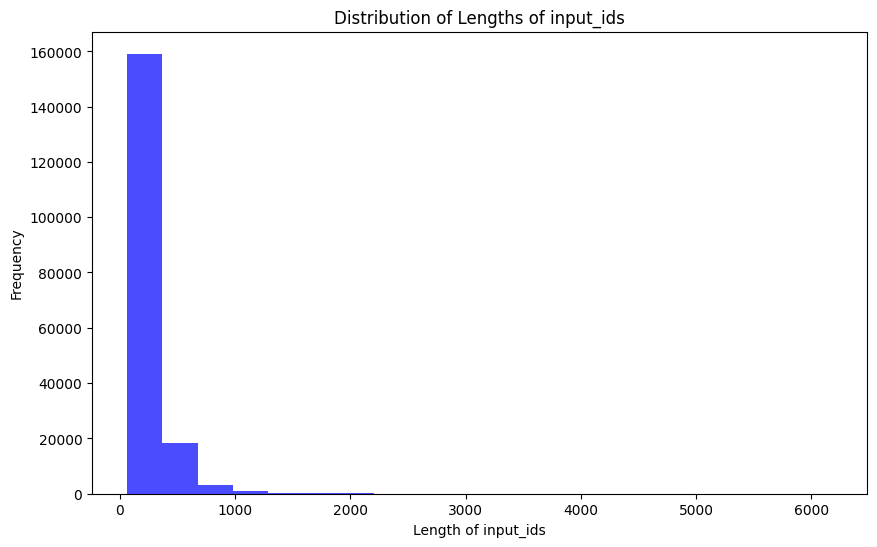

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenize_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
tokenized_train_dataset = tokenized_train_dataset.filter(lambda example: len(example['input_ids']) <= 512)
tokenized_val_dataset = tokenized_val_dataset.filter(lambda example: len(example['input_ids']) <= 512)
print(len(tokenized_train_dataset))
print(len(tokenized_val_dataset))

Filter:   0%|          | 0/180993 [00:00<?, ? examples/s]

Filter:   0%|          | 0/915 [00:00<?, ? examples/s]

171265
870


now we can re-write the tokenize function with a new max_length

In [ ]:
def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        padding="max_length",
        max_length=512,
    )
    result["labels"] = result["input_ids"].copy()
    return result

def tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)
    return tokenize(full_prompt)

In [ ]:
tokenized_train_dataset = train_dataset.map(tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(tokenize_prompt)

Map:   0%|          | 0/180993 [00:00<?, ? examples/s]

Map:   0%|          | 0/915 [00:00<?, ? examples/s]

181908


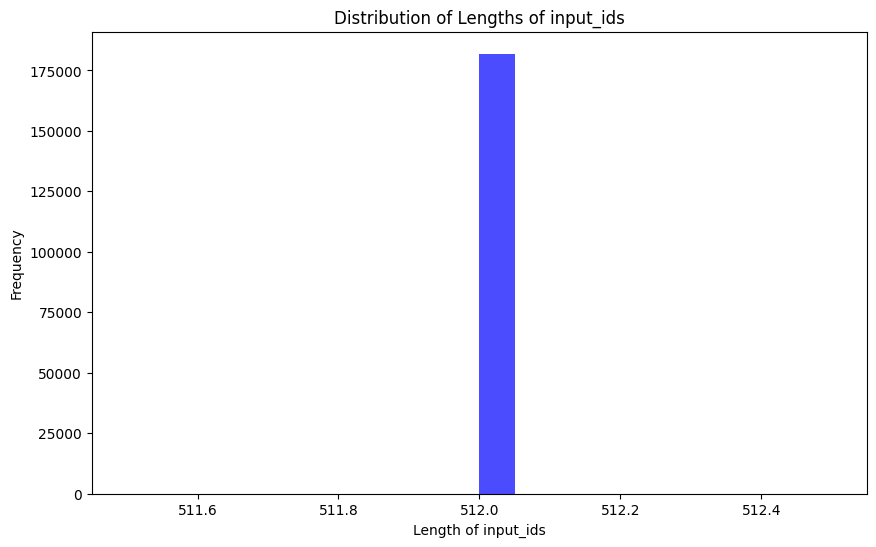

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

how well does base model do?   Not so great

In [ ]:
sample = eval_dataset[2].copy()
print(generate_prompt(sample))
print("----------------")
sample['cop'] = ''
sample['exp'] = ''
print(generate_tokens(generate_prompt(sample), 32))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


You are a helpful medical assistant. Your task is to answer the following question one of the options and explain why.
### Question:  Aspirin-sensitive asthma is associated with - [0] Obesity [1] Urticarisis [2] Nasal polyp [3] Extrinsic asthma
    
### Answer: 2
### Explanation: None
----------------
<s> You are a helpful medical assistant. Your task is to answer the following question one of the options and explain why.
### Question:  Aspirin-sensitive asthma is associated with - [0] Obesity [1] Urticarisis [2] Nasal polyp [3] Extrinsic asthma
    
### Answer: </s>с

### Explanation:

Aspirin-sensitive asthma is associated with urticaria.

Aspirin


In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_disable()
model = prepare_model_for_kbit_training(model)

print_trainable_parameters(model)

trainable params: 0 || all params: 3752071168 || trainable%: 0.0


In [ ]:
from peft import LoraConfig, get_peft_model
model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
        r=16,
        lora_alpha=16,
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ]
    )
model = get_peft_model(model, peft_config)

In [ ]:
print_trainable_parameters(model)

trainable params: 42520576 || all params: 3794591744 || trainable%: 1.1205573318192514


In [ ]:
print_gpu_utilization()

GPU memory occupied: 8181 MB.


In [ ]:
import transformers
from datetime import datetime

project = "finetune"
base_model_name = "medmistral"
run_name = base_model_name + "-" + project
output_dir = gdrive_path + "/" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    # compute_metrics=compute_metrics,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        save_total_limit=3,
        load_best_model_at_end=False,
        warmup_steps=5,
        per_device_train_batch_size=40,
        per_device_eval_batch_size=40,
        gradient_accumulation_steps=1,
        num_train_epochs=2,
        learning_rate=2.5e-5, # Want about 10x smaller than the Mistral learning rate
        logging_steps=100,
        bf16=True,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=1000,
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=100,               # Evaluate and save checkpoints every 100 steps
        do_eval=True,                # Perform evaluation at the end of training
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
# trainer.train()
trainer.train(resume_from_checkpoint = True)

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
8100,1.093500,1.132244
8200,1.090600,1.132618
8300,1.101600,1.132249
8400,1.090700,1.132130
8500,1.090800,1.132056
8600,1.099700,1.131883
8700,1.085600,1.131928
8800,1.089800,1.131799
8900,1.094400,1.131664
9000,1.087500,1.131648


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=9050, training_loss=0.1267592781024743, metrics={'train_runtime': 10883.0104, 'train_samples_per_second': 33.262, 'train_steps_per_second': 0.832, 'total_flos': 7.954487066832667e+18, 'train_loss': 0.1267592781024743, 'epoch': 2.0})

In [ ]:
print_gpu_utilization()

GPU memory occupied: 35245 MB.


In [ ]:
from huggingface_hub import HfApi
api = HfApi()

new_model = "MedMistral-7B"
api.upload_folder(
    folder_path=f"{gdrive_path}/medmistral-finetune/checkpoint-9000",
    repo_id=f"matthewchung74/{new_model}",
    repo_type="model",
)

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/86.9M [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/170M [00:00<?, ?B/s]

'https://huggingface.co/matthewchung74/medmistral/tree/main/'